<a href="https://colab.research.google.com/github/tino926/new_ai_scripts/blob/main/huggingface_diffusers/huggingface_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ref: <https://machinelearningmastery.com/inpainting-and-outpainting-with-diffusers/>  
ref: <https://huggingface.co/docs/diffusers/using-diffusers/inpaint>  
ref: <https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers_doc/en/inpaint.ipynb#scrollTo=9Apdxcp_-kA3>  
ref: <https://medium.com/@nimritakoul01/image-inpainting-using-stable-diffusion-from-hugging-face-d68a26da9fd2>  

In [ ]:
import numpy as np
import torch
import cv2
from PIL import Image
import requests
import PIL
from io import BytesIO
from google.colab.patches import cv2_imshow
!pip install diffusers

!pip install diffusers accelerate
from diffusers import StableDiffusionInpaintPipeline

# install facebook SAM
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything import sam_model_registry, SamPredictor

!wget -q -nc https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
CHECKPOINT_PATH='/content/sam_vit_b_01ec64.pth'

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
MODEL_TYPE = "vit_b"

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bgtj0ilw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bgtj0ilw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
cpu


In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` 

In [ ]:
def get_image_as_pil_rgb(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = get_image_as_pil_rgb(img_url).resize((512, 512))
mask_image = get_image_as_pil_rgb(mask_url).resize((512, 512))

# import matplotlib.pyplot as plt
# # Display images
# plt.figure(figsize=(10, 5))

# # Show the initial image
# plt.subplot(1, 2, 1)
# plt.title("Initial Image")
# plt.imshow(init_image)
# plt.axis("off")

# # Show the mask image
# plt.subplot(1, 2, 2)
# plt.title("Mask Image")
# plt.imshow(mask_image)
# plt.axis("off")

# plt.show()

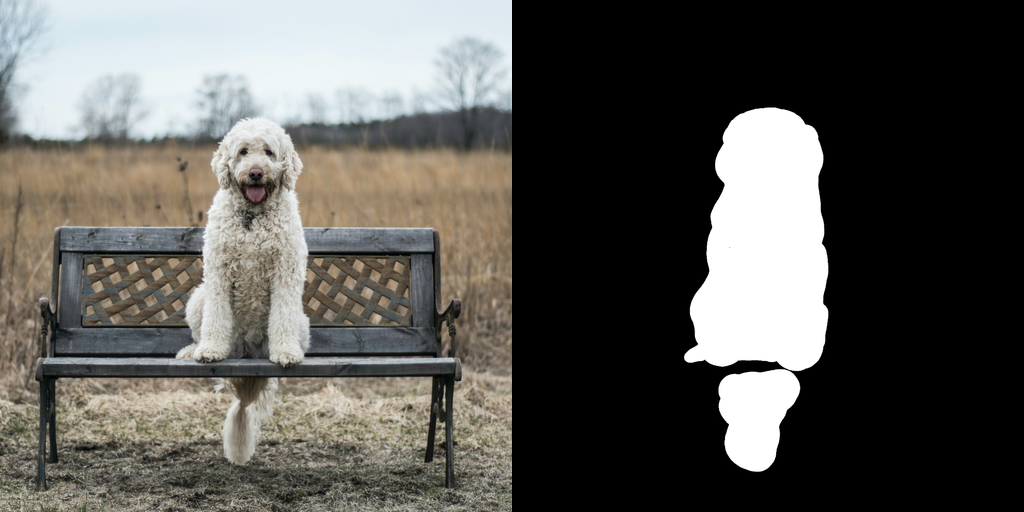

In [ ]:
init_image_cv2 = cv2.cvtColor(np.array(init_image), cv2.COLOR_RGB2BGR)
mask_image_cv2 = cv2.cvtColor(np.array(mask_image), cv2.COLOR_RGB2BGR)

cv2_imshow(cv2.hconcat([init_image_cv2, mask_image_cv2]))

In [ ]:
# init_image_cv2 = cv2.resize(cv2.imread("test.png"), (1024, 1024))
# mask_image_cv2 = cv2.resize(cv2.imread("test_mask.png"), (1024, 1024))
init_image_cv2 = cv2.imread("test.png")[0:512, 100:612, :]
mask_image_cv2 = cv2.imread("test_mask.png")[0:512, 100:612, :]
cv2_imshow(cv2.hconcat([init_image_cv2, mask_image_cv2]))

TypeError: 'NoneType' object is not subscriptable

In [ ]:
prompt = ""

# convert image and mask back to pil format
print(init_image_cv2.shape)
i_in=Image.fromarray(cv2.cvtColor(init_image_cv2, cv2.COLOR_BGR2RGB))
m_in=Image.fromarray(cv2.cvtColor(mask_image_cv2, cv2.COLOR_BGR2RGB))
image = pipe(prompt=prompt, image=i_in, mask_image=m_in, num_inference_steps=200, seed=0).images[0]

# convert image to opencv mat
image_cv = cv2.resize(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), init_image_cv2.shape[1::-1], interpolation=cv2.INTER_CUBIC)
cv2_imshow(image_cv)

(512, 512, 3)


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# convert image to opencv mat

# convert image to opencv mat
image_cv = cv2.resize(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), init_image_cv2.shape[1::-1], interpolation=cv2.INTER_CUBIC)
cv2_imshow(image_cv)

  0%|          | 0/50 [00:00<?, ?it/s]

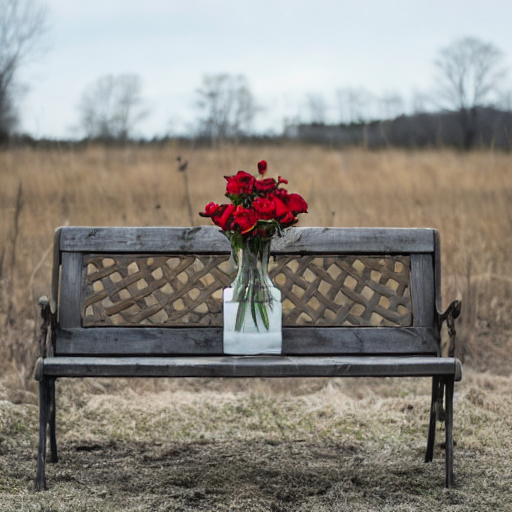

In [ ]:
prompt = "red roses in a tall vase"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
# convert image to opencv mat
# image.save('output2.png')
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
cv2_imshow(image_cv)

In [ ]:
!wget https://machinelearningmastery.com/wp-content/uploads/2024/04/inpaint-example.png

--2024-12-06 01:47:41--  https://machinelearningmastery.com/wp-content/uploads/2024/04/inpaint-example.png
Resolving machinelearningmastery.com (machinelearningmastery.com)... 104.26.1.148, 104.26.0.148, 172.67.72.46, ...
Connecting to machinelearningmastery.com (machinelearningmastery.com)|104.26.1.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107796 (105K) [image/png]
Saving to: ‘inpaint-example.png.2’

inpaint-example.png 100%[===================>] 105.27K  --.-KB/s    in 0.02s   

2024-12-06 01:47:41 (4.17 MB/s) - ‘inpaint-example.png.2’ saved [107796/107796]



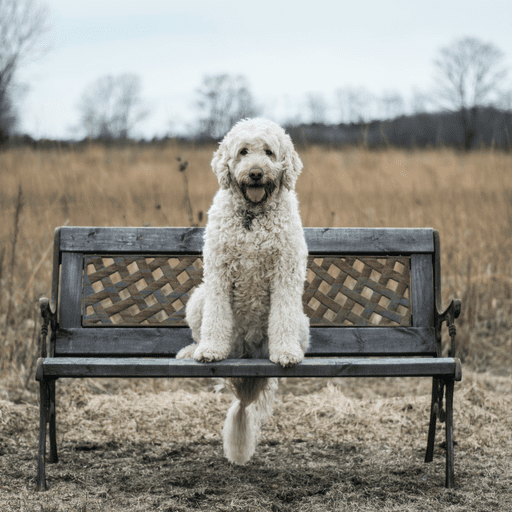

In [ ]:
# Give the path of your image
IMAGE_PATH = '/content/inpaint-example.png'
# Read the image from the path
image = cv2.imread(IMAGE_PATH)
cv2_imshow(image)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [ ]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

# Provide points as input prompt [X, Y]-coordinates
input_point = np.array([[250, 250]])
input_label = np.array([1])

# Predicting Segmentation mask
masks, scores, logits = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

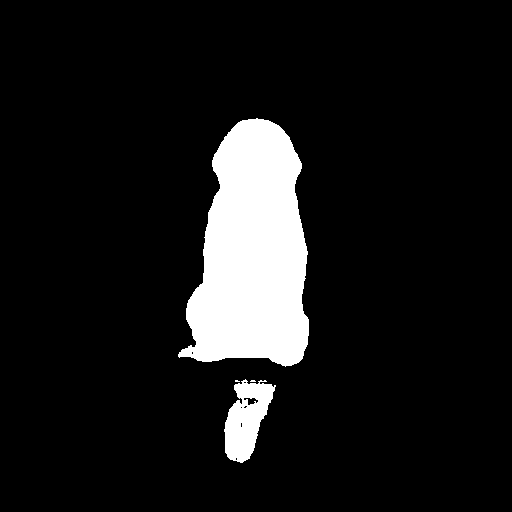

NameError: name 'sam' is not defined

In [ ]:
mask = masks.astype(float) * 255
mask = np.transpose(mask, (1, 2, 0))
_ , bw_image = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
cv2_imshow(bw_image)
cv2.imwrite('mask.png', bw_image)
del sam, mask_predictor   # delete models to conserve GPU memory

In [ ]:
# !pip install --upgrade transformers diffusers

In [ ]:
# Load images using PIL
init_image = Image.open(IMAGE_PATH)
mask_image = Image.open('mask.png')

import requests
import PIL
from io import BytesIO
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


# img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
# mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

# init_image = download_image(img_url).resize((512, 512))
# mask_image = download_image(mask_url).resize((512, 512))


# pipe = StableDiffusionInpaintPipeline.from_pretrained(
#     "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
# )
# pipe = pipe.to(DEVICE)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

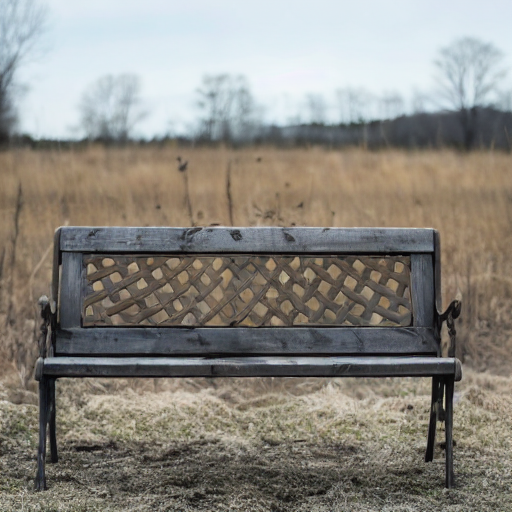

In [ ]:
prompt = ""
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
# convert image to opencv mat
image.save('output1.png')

image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
cv2_imshow(image_cv)

  0%|          | 0/50 [00:00<?, ?it/s]

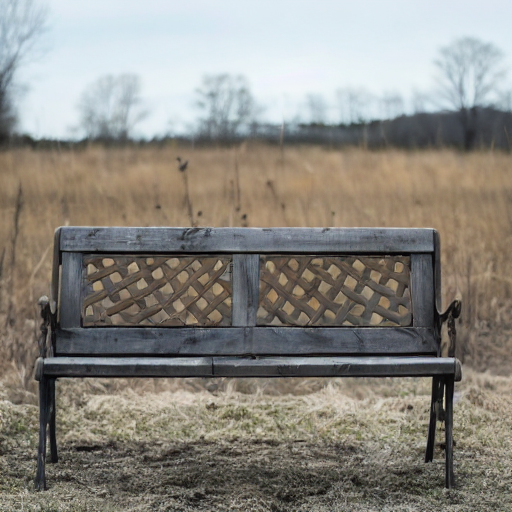

In [ ]:
prompt = ""
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
# convert image to opencv mat
image.save('output1.png')

image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
cv2_imshow(image_cv)

  0%|          | 0/50 [00:00<?, ?it/s]

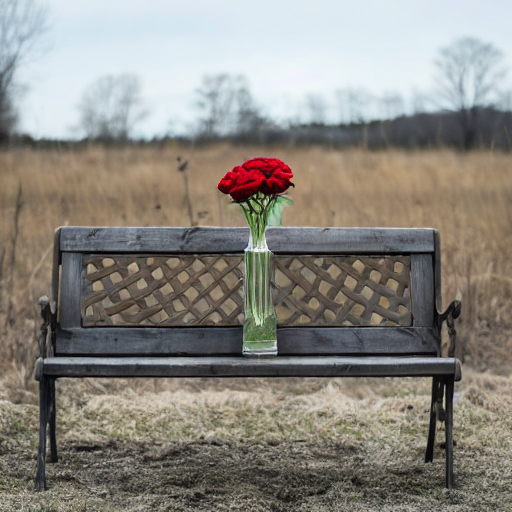

In [ ]:
prompt = "red roses in a tall vase"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]
# convert image to opencv mat
image.save('output2.png')

image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
cv2_imshow(image_cv)


In [ ]:
init_image = PIL.Image.open("test.png")
mask_image = PIL.Image.open('test_mask.png')

init_image = init_image.resize((512, 512))
mask_image = mask_image.resize((512, 512))

init_image.convert("RGB")
mask_image.convert("RGB")


# init_image.mode

prompt = ""
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
cv2_imshow(image_cv)

  0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 512 for tensor number 2 in the list.